In [1]:
import os
import PIL
import PIL.Image
import pathlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


import imgaug as ia
from imgaug import augmenters as iaa

from pathlib import Path

In [2]:
 def downscale_images(images, scale=30):
    """
    Downscales images in an array.
    Args:
        images: array of images to be downscaled 
        scale: 

    Returns: array of downscaled down images

    """
    resized = []
    
    for img in images:
        
        width = int(img.shape[1] * scale / 100)
        height = int(img.shape[0] * scale / 100)
        dim = (width, height)

        resized.append(cv2.resize(img, dim, interpolation = cv2.INTER_AREA))
    
    return resized


In [3]:
def bgr_to_rgb(images):
    return [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in images]

In [4]:
def load_paintings(path):
    """
    Loads all paintings from a directory. 
    Args:
        path: the directory with the paintings

    Returns: 
        sorted list of filenames, list of loaded paintings sorted by filename

    """
    
    # directory with the images
    data_dir = pathlib.Path(path)
    
    # how many images are in the directory
    image_count = len(list(data_dir.glob('*')))
    print(f"Number of images found in {path}: {image_count}")

    paintings_path = list(data_dir.glob('*'))
    paintings_path = [str(path) for path in paintings_path]
    paintings_path = sorted(paintings_path)
    
    # set this if you only want to augment a range of paintings
    # paintings_path = paintings_path[:500]
    
    paintings_filenames = [path.split('/')[-1] for path in paintings_path]
    
    
    # loading images, in BGR
    paintings = [cv2.imread(painting_path) for painting_path in paintings_path]
    
    # converting to rgb, because the augmenter does not work with bgr
    paintings = bgr_to_rgb(paintings)
        
    return paintings_filenames, paintings


In [5]:
# the directory with paintings to augment
to_augment_dir = "../datasets/example_oil/"

# load the paintings, including their filenames (new filename is prefix+old filename)
paintings_filenames, paintings = load_paintings(to_augment_dir)

Number of images found in ../datasets/example_oil/: 12


# Data Augmentation

## Imgaug

In [6]:
def compare_orig_aug(orig, aug, limit = 15):
    """
    Compares a number of original and augmented images. 
    A relatively low limit should be set to avoid memory errors. 
    Args:
        orig: list of original paintings
        aug: list of augmented paintings
        limit: how many paintings to compare
    """
    for i in range(0, len(orig)): 
        if i == limit:
            break
        
        ia.imshow(np.hstack([orig[i], aug[i]]))
        

In [7]:
def get_augmented(images, augmenters_list):
    """
    Augments all images given in parameter according to augmentation params.
    Args:
        images: paintings to augment
        augmenters_list: the list of augmenters to use

    Returns: list of augmented images

    """
    
    seq = iaa.Sequential(augmenters_list, random_order = True)
    
    augmented = seq(images=images)
        
    return augmented
    


### Augmenters list
This list defines the augmenters which will be used in a sequential/random order.

In [8]:
# specify the augmentors to be used
augmenters_list = [
    
    # Gaussian blur images with a sigma from range
    iaa.GaussianBlur(sigma=(0, 5.0)), 
    
    # apply JpegCompression on some images
    # degrade the quality of images by JPEG-compressing them. 
    iaa.Sometimes(0.50,
                iaa.JpegCompression(compression=(0, 30)) ), 
        
    iaa.Affine(
        scale=(0.3,2), # zooming in/out
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # shifting on axis
        rotate=(-50, 50), # rotating
        ),
    
    # crops images from each side 
    # iaa.Crop(px=(0, 16)), 
    
    # changes contrast
    iaa.LinearContrast((0.75, 1.5)),
        
    # sometimes cut a square hole in an image and fill it with noise
    iaa.Sometimes(0.25,
        iaa.Cutout(fill_mode="gaussian", fill_per_channel=True) ),
        
    ]

In [9]:
# augment the images
augmented = get_augmented(paintings, augmenters_list)

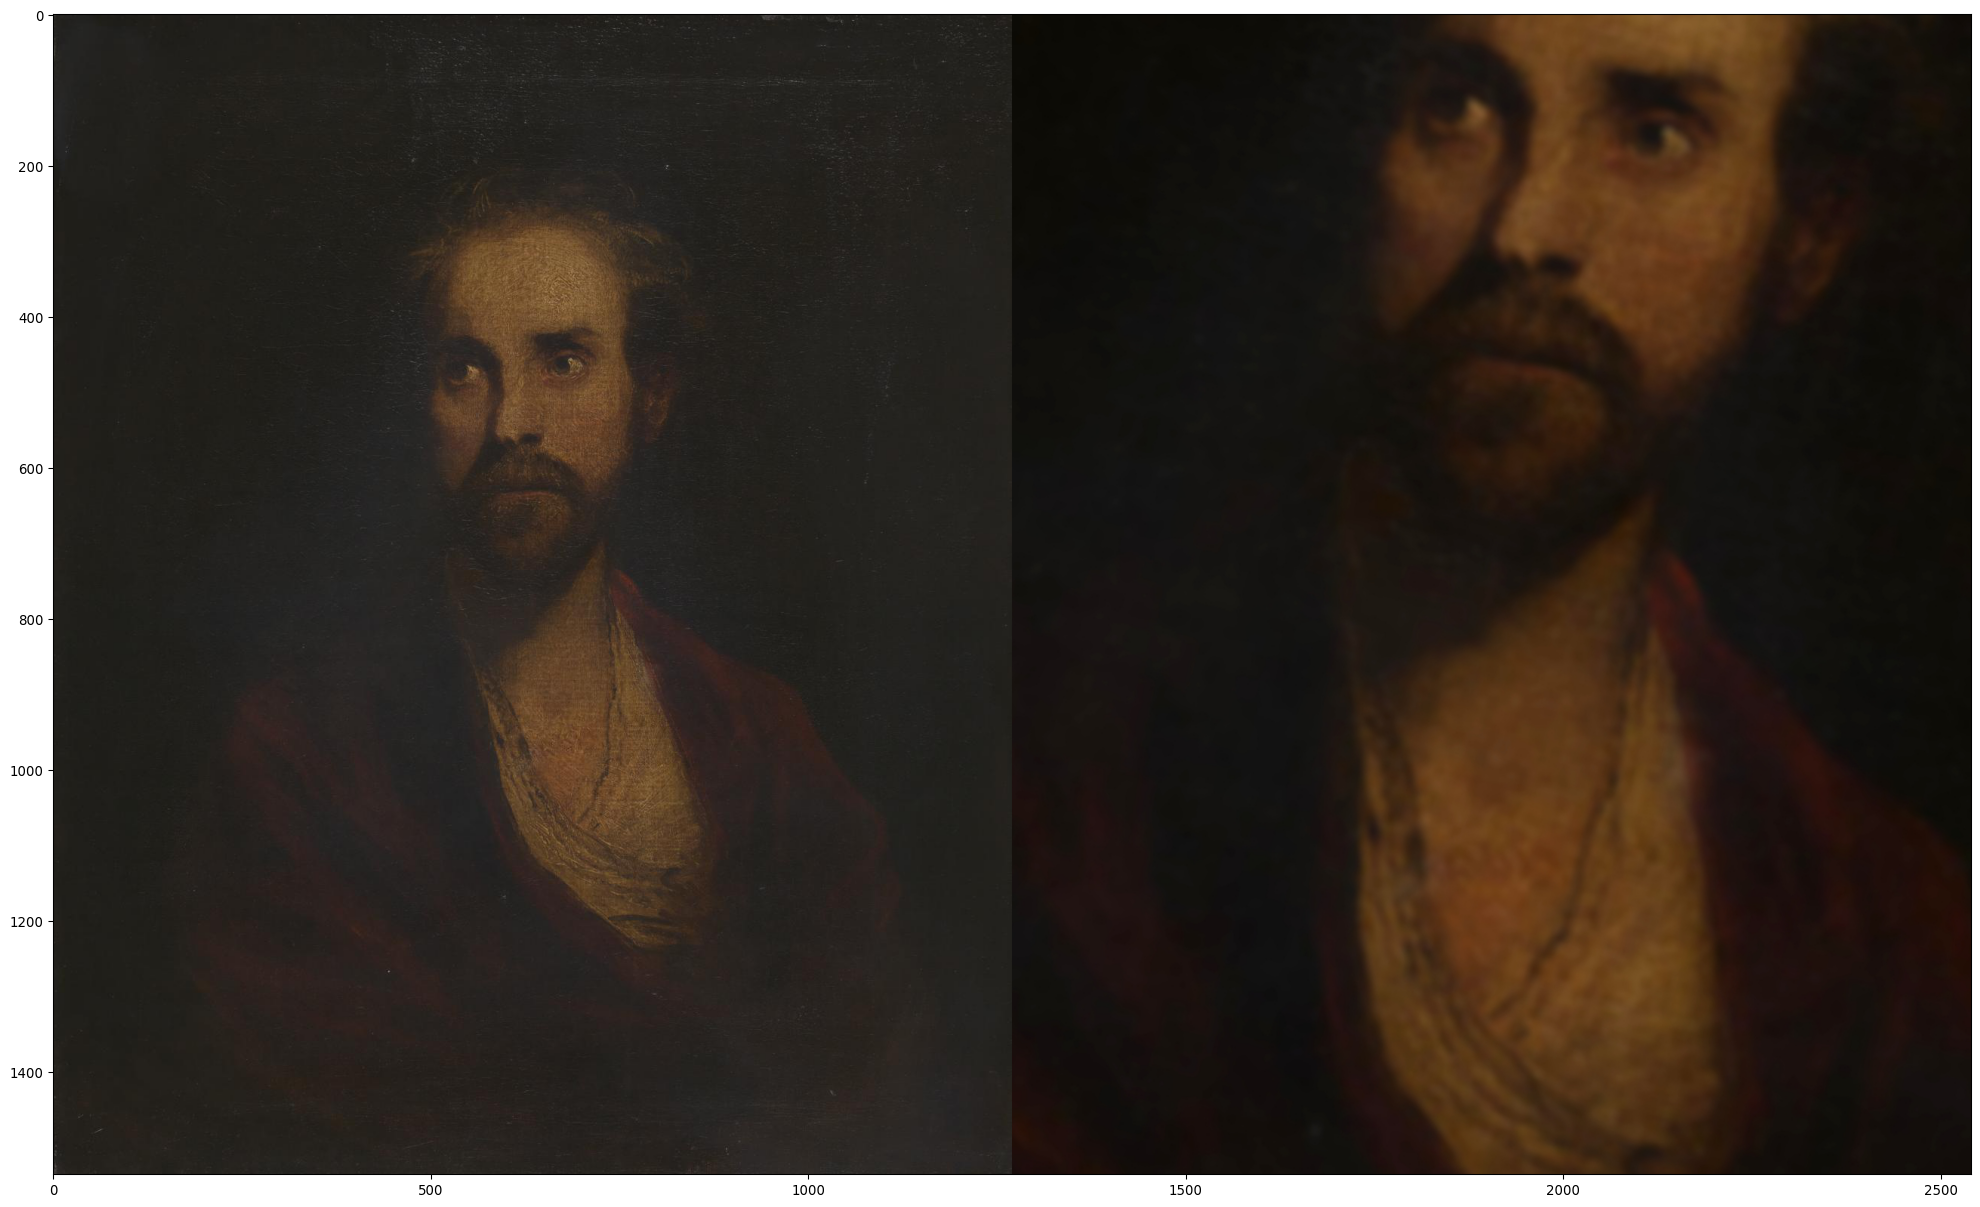

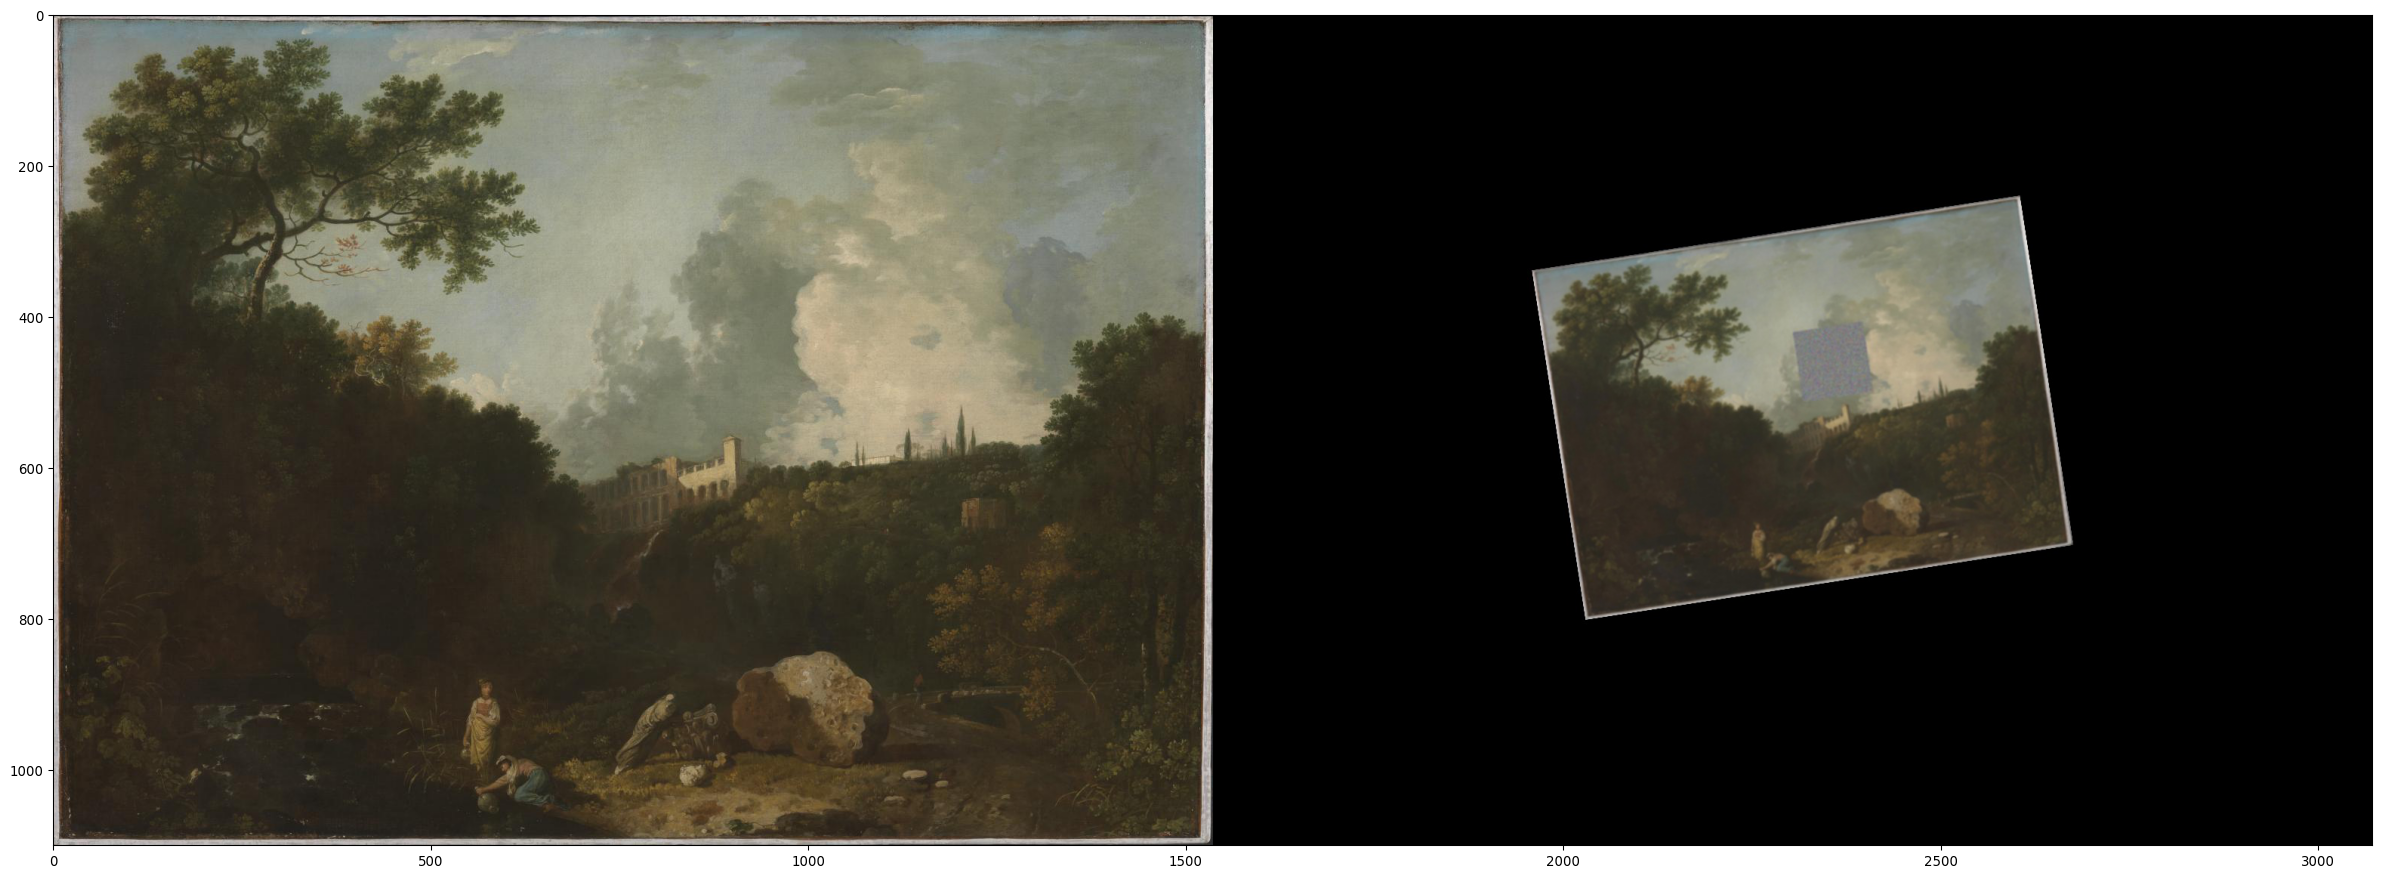

In [10]:
compare_orig_aug(paintings, augmented, limit=2)

In [11]:
def save_images(dest_dir, paintings_filenames, images):
    """
    Saves the augmented image.
    Args:
        dest_dir: directory where to save
        paintings_filenames: original painting names (sorted)
        images: augmented images (sorted by orig. filename)

    """
    
    # create the directory where the augmented images will be stored
    dir_path = Path.cwd() / dest_dir
    dir_path.mkdir(parents=True, exist_ok=True)
    
    for filename, image in zip(paintings_filenames, images):
        
        filename = "aug_" + filename
        
        path = Path.cwd() / dest_dir / filename
        path = str(path)
        
        im_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path, im_bgr)
        
    print("Saving finished.")

            

In [12]:
# the name of the destination folder
aug_dir = to_augment_dir.split('/')[-2] + "_aug/"

# save the augmented paintings in the folder
save_images(aug_dir, paintings_filenames, augmented)

Saving finished.
